In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/power-conumption/powerconsumption.csv


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import r2_score

2024-09-15 09:15:09.379712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 09:15:09.379872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 09:15:09.534924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [5]:
df=pd.read_csv("/kaggle/input/power-conumption/powerconsumption.csv")
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


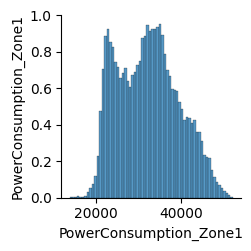

In [6]:
sns.pairplot(df[['PowerConsumption_Zone1']])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [8]:
df.isnull().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [9]:
df['Datetime']=pd.to_datetime(df.Datetime)
print(df)

                 Datetime  Temperature  Humidity  WindSpeed  \
0     2017-01-01 00:00:00        6.559      73.8      0.083   
1     2017-01-01 00:10:00        6.414      74.5      0.083   
2     2017-01-01 00:20:00        6.313      74.5      0.080   
3     2017-01-01 00:30:00        6.121      75.0      0.083   
4     2017-01-01 00:40:00        5.921      75.7      0.081   
...                   ...          ...       ...        ...   
52411 2017-12-30 23:10:00        7.010      72.4      0.080   
52412 2017-12-30 23:20:00        6.947      72.6      0.082   
52413 2017-12-30 23:30:00        6.900      72.8      0.086   
52414 2017-12-30 23:40:00        6.758      73.0      0.080   
52415 2017-12-30 23:50:00        6.580      74.1      0.081   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
0                    0.051         0.119             34055.69620   
1                    0.070         0.085             29814.68354   
2                    0.062         0.10

In [10]:
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

In [11]:
chronological_order, equidistant_timestamps

(True, True)

In [12]:
df = df.set_index('Datetime')

In [13]:

    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

In [14]:

print( df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter']].head())

    

                     year  month  day  minute  dayofyear  weekofyear  quarter
Datetime                                                                     
2017-01-01 00:00:00  2017      1    1       0          1          52        1
2017-01-01 00:10:00  2017      1    1      10          1          52        1
2017-01-01 00:20:00  2017      1    1      20          1          52        1
2017-01-01 00:30:00  2017      1    1      30          1          52        1
2017-01-01 00:40:00  2017      1    1      40          1          52        1


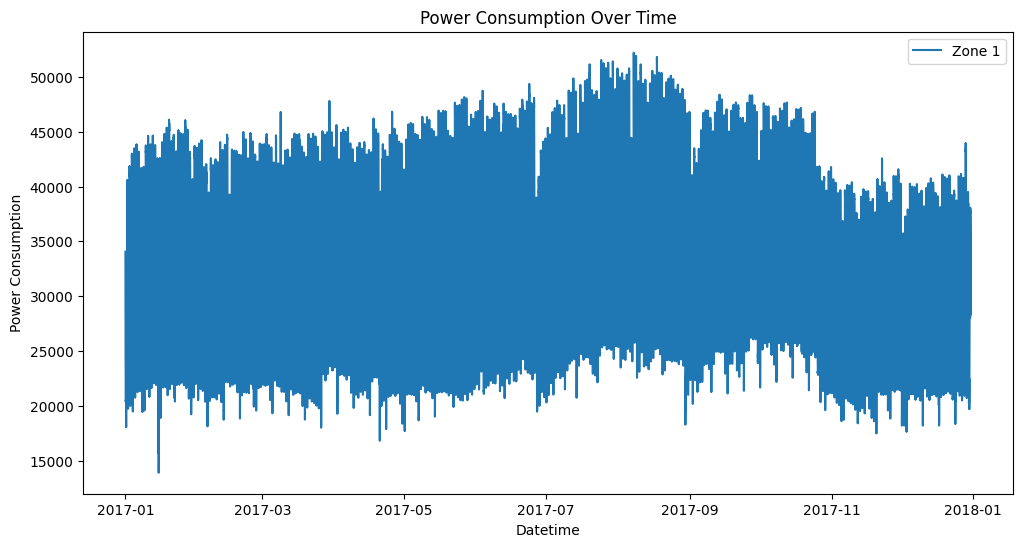

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

In [16]:
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,minute,dayofweek,quarter,month,day,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,0,6,1,1,1,2017,1,1,52
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,10,6,1,1,1,2017,1,1,52
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,20,6,1,1,1,2017,1,1,52
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,30,6,1,1,1,2017,1,1,52
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,40,6,1,1,1,2017,1,1,52


In [17]:
df.isna().sum()

Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
hour                      0
minute                    0
dayofweek                 0
quarter                   0
month                     0
day                       0
year                      0
dayofyear                 0
dayofmonth                0
weekofyear                0
dtype: int64

 Multilayer Perceptron model

In [18]:

    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))
    
    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)
    
    # Minute-level features
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']
    
    

In [19]:
df.head()


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,minute,...,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_working_day,is_business_hours,is_peak_hour,minute_of_day,minute_of_week
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,0,...,1,1,0,True,False,0,0,0,0,8640
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,10,...,1,1,0,True,False,0,0,0,10,8650
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,20,...,1,1,0,True,False,0,0,0,20,8660
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,30,...,1,1,0,True,False,0,0,0,30,8670
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,40,...,1,1,0,True,False,0,0,0,40,8680


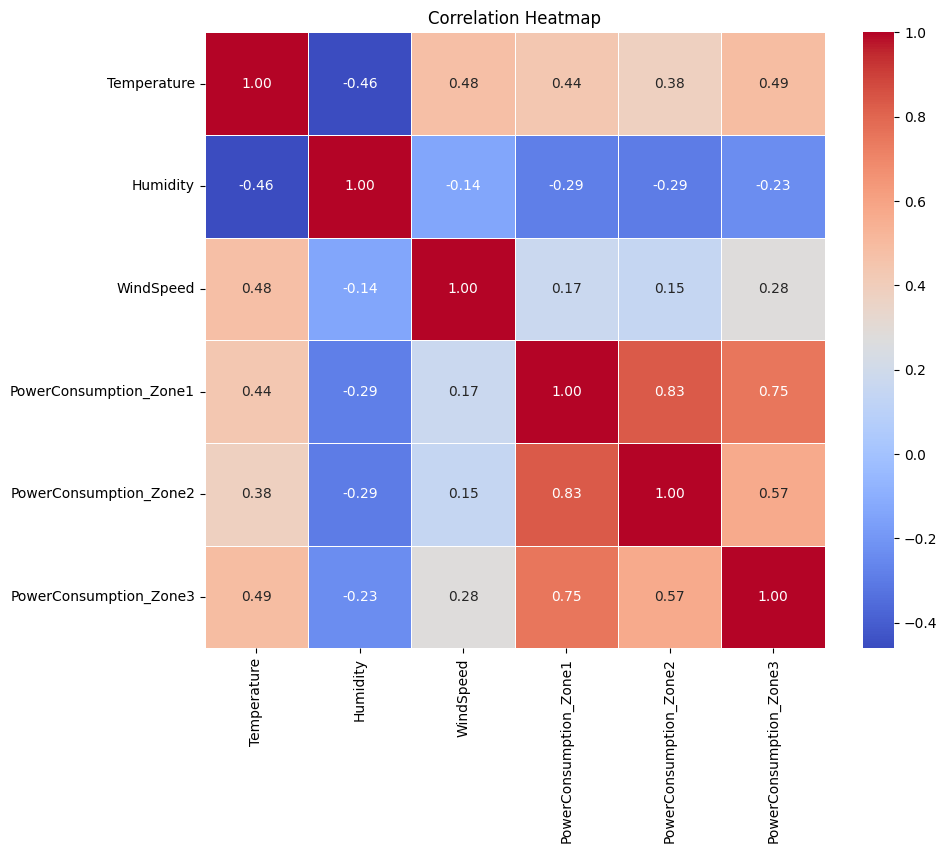

In [20]:
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

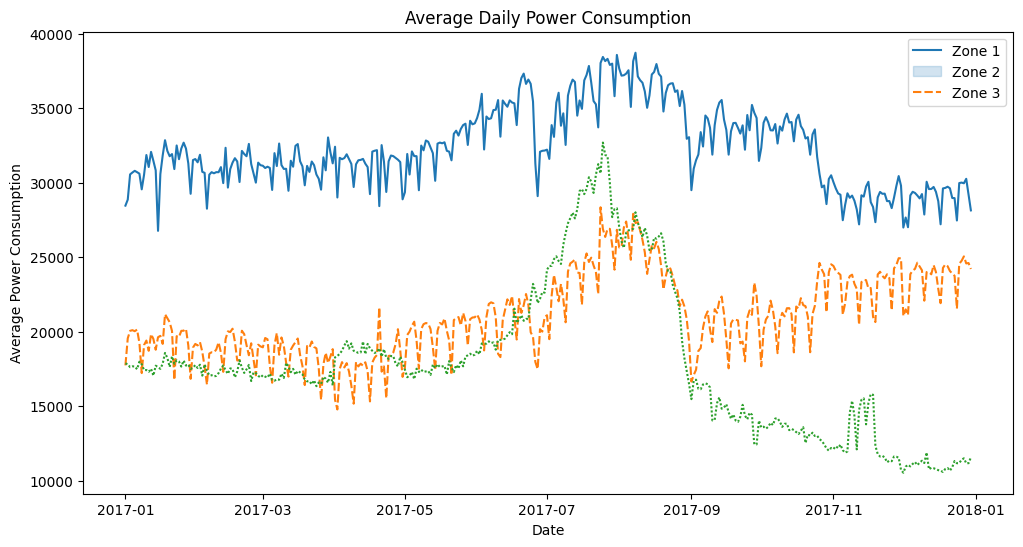

In [21]:
daily_resampled = df.resample('D').mean()

# Plot daily Power Consumption for each zone
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler

# Separate the input features (X) and target variables (y)
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Initialize StandardScaler for y
scaler_y = StandardScaler()

# Fit and transform  y
y_scaled = scaler_y.fit_transform(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

In [24]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [25]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(3))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,003 (11.73 KB)

 Trainable params: 3,003 (11.73 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
mlp_history = model_mlp.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 3s - 2ms/step - loss: 4237.9814 - val_loss: 93.7690
Epoch 2/40
1229/1229 - 2s - 1ms/step - loss: 26.3371 - val_loss: 32.5730
Epoch 3/40
1229/1229 - 2s - 1ms/step - loss: 10.6470 - val_loss: 23.0164
Epoch 4/40
1229/1229 - 2s - 1ms/step - loss: 6.2289 - val_loss: 11.5567
Epoch 5/40
1229/1229 - 2s - 2ms/step - loss: 4.0135 - val_loss: 8.6907
Epoch 6/40
1229/1229 - 2s - 1ms/step - loss: 2.7457 - val_loss: 4.9112
Epoch 7/40
1229/1229 - 2s - 2ms/step - loss: 2.2228 - val_loss: 2.8229
Epoch 8/40
1229/1229 - 2s - 2ms/step - loss: 2.1817 - val_loss: 4.7904
Epoch 9/40
1229/1229 - 2s - 1ms/step - loss: 1.8767 - val_loss: 3.9739
Epoch 10/40
1229/1229 - 2s - 2ms/step - loss: 1.7939 - val_loss: 2.5998
Epoch 11/40
1229/1229 - 2s - 2ms/step - loss: 1.6474 - val_loss: 2.6639
Epoch 12/40
1229/1229 - 2s - 1ms/step - loss: 1.8976 - val_loss: 1.5747
Epoch 13/40
1229/1229 - 2s - 1ms/step - loss: 1.4651 - val_loss: 1.9695
Epoch 14/40
1229/1229 - 2s - 2ms/step - loss: 1.3108 - val_loss:

In [27]:
X_train.shape

(39312, 26)

In [28]:
y_test

array([[-0.08265162, -0.58781045, -0.44343015],
       [-0.16396171, -0.65960705, -0.49895022],
       [-0.30713819, -0.74863482, -0.53067598],
       ...,
       [-0.38624194,  0.81423659, -0.60840556],
       [-0.47497346,  0.70167962, -0.65278385],
       [-0.56029223,  0.57921197, -0.67801856]])

In [29]:
train_predict = model_mlp.predict(X_train)
test_predict = model_mlp.predict(X_test)


# Calculate MSE and MAE as you already did
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Print the results
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

1229/1229 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
Mean squared error on test set: 2.6195
Mean absolute error on test set: 1.4298


In [30]:
test_predict

array([[-0.77406853,  0.5617379 ,  1.2528853 ],
       [-0.78120965,  0.5456246 ,  1.2379928 ],
       [-0.78239983,  0.53891075,  1.2344985 ],
       ...,
       [ 1.2116722 ,  2.586152  ,  0.885057  ],
       [ 1.1316246 ,  2.518159  ,  0.8401809 ],
       [ 1.0565513 ,  2.450776  ,  0.79734945]], dtype=float32)

CNN MODEL

In [31]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (39312, 26, 1)
Validation set shape (13104, 26, 1)


In [32]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(3))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        38,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,803 (175.02 KB)

 Trainable params: 38,795 (151.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,008 (23.47 KB)

In [33]:
X_train_series = np.array(X_train_series, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test_series = np.array(X_test_series, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [34]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

# Compile the model with the new optimizer
model_cnn.compile(optimizer=optimizer, loss='mse')

In [35]:
cnn_history = model_cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 4s - 3ms/step - loss: 42.2591 - val_loss: 1.9293
Epoch 2/40
1229/1229 - 3s - 3ms/step - loss: 0.5439 - val_loss: 0.6324
Epoch 3/40
1229/1229 - 3s - 3ms/step - loss: 0.9007 - val_loss: 0.5458
Epoch 4/40
1229/1229 - 3s - 3ms/step - loss: 0.9748 - val_loss: 1.2263
Epoch 5/40
1229/1229 - 3s - 2ms/step - loss: 1.1066 - val_loss: 2.6097
Epoch 6/40
1229/1229 - 3s - 2ms/step - loss: 1.0923 - val_loss: 1.3279
Epoch 7/40
1229/1229 - 3s - 2ms/step - loss: 0.7391 - val_loss: 0.7994
Epoch 8/40
1229/1229 - 3s - 2ms/step - loss: 0.7622 - val_loss: 1.7673
Epoch 9/40
1229/1229 - 3s - 2ms/step - loss: 0.6886 - val_loss: 0.8719
Epoch 10/40
1229/1229 - 3s - 2ms/step - loss: 0.5403 - val_loss: 0.7976
Epoch 11/40
1229/1229 - 3s - 2ms/step - loss: 0.5323 - val_loss: 0.5025
Epoch 12/40
1229/1229 - 3s - 3ms/step - loss: 0.3699 - val_loss: 1.0749
Epoch 13/40
1229/1229 - 3s - 2ms/step - loss: 0.4670 - val_loss: 1.0145
Epoch 14/40
1229/1229 - 3s - 2ms/step - loss: 0.2890 - val_loss: 1.9338


In [36]:
train_predict = model_cnn.predict(X_train)
test_predict = model_cnn.predict(X_test)


# Calculate MSE and MAE as you already did
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Print the results
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

1229/1229 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean squared error on test set: 0.3663
Mean absolute error on test set: 0.4802


LSTM MODEL

In [37]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(3))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,561 (64.70 KB)

 Trainable params: 10,553 (41.22 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,008 (23.47 KB)

In [38]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

# Compile the model with the new optimizer
model_lstm.compile(optimizer=optimizer, loss='mse')

In [39]:
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 14s - 11ms/step - loss: 31.7777 - val_loss: 1.2633
Epoch 2/40
1229/1229 - 12s - 10ms/step - loss: 0.4682 - val_loss: 0.9042
Epoch 3/40
1229/1229 - 12s - 10ms/step - loss: 0.3900 - val_loss: 1.3082
Epoch 4/40
1229/1229 - 20s - 16ms/step - loss: 0.3018 - val_loss: 1.4361
Epoch 5/40
1229/1229 - 12s - 9ms/step - loss: 0.2539 - val_loss: 0.7864
Epoch 6/40
1229/1229 - 12s - 9ms/step - loss: 0.2596 - val_loss: 0.7520
Epoch 7/40
1229/1229 - 11s - 9ms/step - loss: 0.2013 - val_loss: 0.4213
Epoch 8/40
1229/1229 - 12s - 9ms/step - loss: 0.1677 - val_loss: 0.5275
Epoch 9/40
1229/1229 - 12s - 9ms/step - loss: 0.1561 - val_loss: 1.5935
Epoch 10/40
1229/1229 - 12s - 9ms/step - loss: 0.1559 - val_loss: 4.0671
Epoch 11/40
1229/1229 - 12s - 9ms/step - loss: 0.1431 - val_loss: 1.6120
Epoch 12/40
1229/1229 - 12s - 9ms/step - loss: 0.4532 - val_loss: 0.8590
Epoch 13/40
1229/1229 - 12s - 10ms/step - loss: 0.1799 - val_loss: 0.5445
Epoch 14/40
1229/1229 - 12s - 10ms/step - loss: 0.1614

In [40]:
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)


# Calculate MSE and MAE as you already did
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Print the results
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

1229/1229 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Mean squared error on test set: 0.4094
Mean absolute error on test set: 0.5293


COMPARING MODELS

Text(0, 0.5, 'MSE')

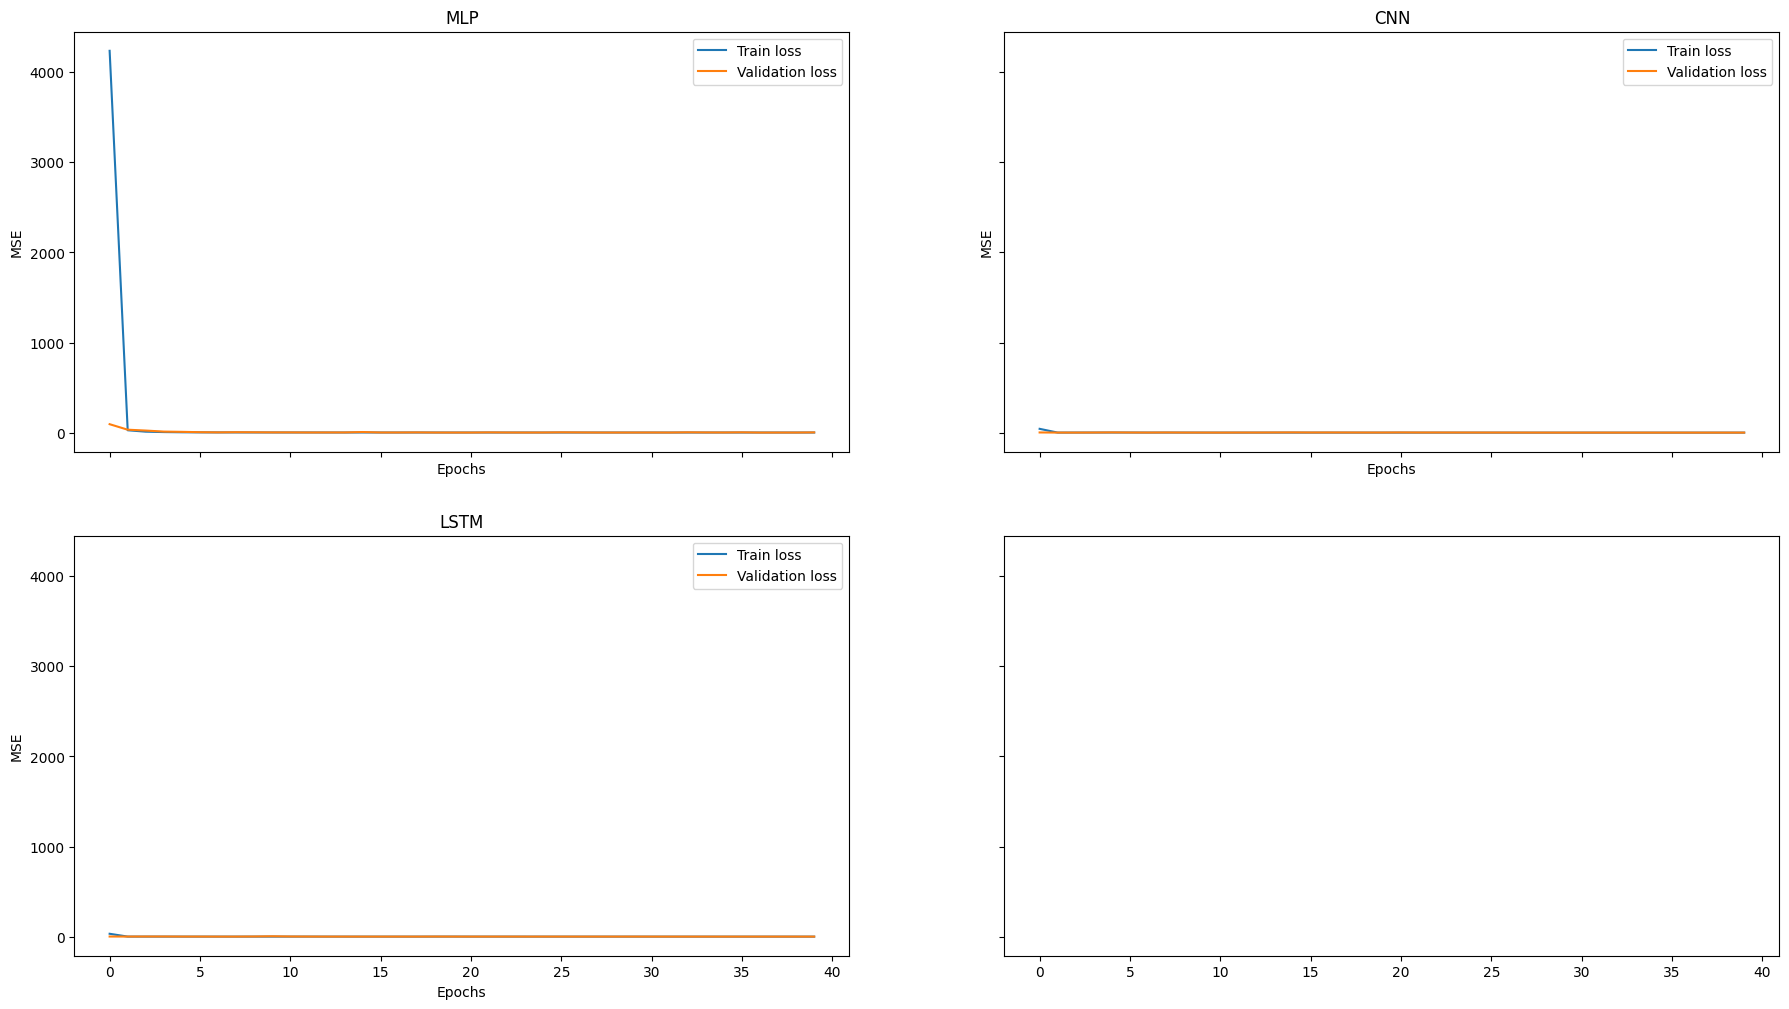

In [53]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')